Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py under the following license:

MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The author's model was based on the paper here: https://arxiv.org/pdf/1511.06434.pdf

## Setup

1. Go to https://colab.research.google.com and choose the \"Upload\" option to upload this notebook file.
1. In the Edit menu, choose \"Notebook Settings\" and then set the \"Hardware Accelerator\" dropdown to GPU.

In [3]:
# upgrade tensorflow to tensorflow 2
%tensorflow_version 2.x
# display matplotlib plots
%matplotlib inline
# why why did i choose this

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow import test
from tensorflow import device

import matplotlib.pyplot as plt
from IPython.display import Image

import sys

import numpy as np

In [0]:
# Global Constants
images_dir = "dcgan_images"
img_rows = 28 
img_cols = 28
channels = 1
noise_len = 100

## Define functions for creating, training, and using the models

In [0]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional
    data representing a black and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    noise_shape = (noise_len,)

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    # Build and compile the generator
    generator = build_generator()

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len,))
    img = generator(noise)
    
    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

def save_imgs(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(iteration)))
    plt.close()

def train(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real images classified as ones and generated images as zeros)
        real = 1
        fake = 0
        # Use noisy labels: about 20% of the time, swap the labels
        # (see https://github.com/soumith/ganhacks)
        # if np.random.randint(0, 5) < 1:
        #   real = 0
        #   fake = 1
        '''
        With 5% reversed labels, the gan seems to peak at around 1500 iterations
        With 20%, it seems like the images peak around 2500 iterations...
          maybe we should just train the generator more before we switch back to
          training the discriminator...

        6 March 2020
            trying to train the generator more than the discriminator... and removing the random reversed label thing because it's really janky
            That didn't work so now I'm going to try training the generator 3 times as much
            Training with 3x generator batch size seems to peak around 1300 iters, and still isn't great.
                It seems like it's almost overfitting to the current generator faults, so maybe we need to train less? 1.5x?
                Next I'm going to try training the model multiple times (multiple backprops), similar to increasing the learning rate
            Doubling the training of the generator doesn't seem to do very much... although it is better than the larger batch sizes
                The doubled generator seems to peak at around 850 iterations
                looking at the generator loss, it seems like the loss doesn't mean much for later iteration numbers so perhaps
                    the generator is just severly overfitting on the discriminator. I will try training the entire thing on smaller batch sizes next
            Smaller batch size (16) with double generator backprop didn't work, although I'm running it again just in case...
                Raising the batch size back to 32 now... and now I'm going to try training the generator with different ratios based on the descriminator
                I will start by raising the number to training the generator 3 times per iter, possibly making the overfitting worse if that is indeed the problem
            The 3x backprop on the generator doesn't do much, although it looks less like a weird barf of colors now. It looks like lines but not digits.
            I guess we will continue on this adventure next time...
        '''
        d_loss_real = discriminator.train_on_batch(imgs, np.zeros((half_batch, 1)) + real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)) + fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # generator_batch_size = 3*batch_size # train the generator on a larger batch for more accurate gradient descent
        generator_batch_size = batch_size
        generator_train_multiplier = 3 # train generator twice for each iteration

        for i in range(generator_train_multiplier):
            noise = np.random.normal(0, 1, (generator_batch_size, noise_len))
            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined.train_on_batch(noise, np.ones((generator_batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(iteration, d_loss[0], d_loss[1], g_loss))
            save_imgs(generator, iteration)
            
def show_new_image(generator):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    noise = np.random.normal(0, 1, (1, noise_len))
    gen_img = generator.predict(noise)[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

## This is the main section of the code, that actually creates the model objects

In [91]:
# set up directories to hold the images that are saved during training checkpoints.
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

print("worked!")

worked!


In [0]:
generator, discriminator, combined = build_combined()

We can take a look at what each of the models look like.

## Training the model

In [94]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
with device('/device:GPU:0'):
  train(generator, discriminator, combined, iterations=2501, batch_size=32, save_interval=50)

0 [D loss: 0.026378778740763664, acc.: 100.00%] [G loss: 1.7504687309265137]
50 [D loss: 0.010597017593681812, acc.: 100.00%] [G loss: 2.700963020324707]
100 [D loss: 0.0008329892880283296, acc.: 100.00%] [G loss: 0.7366304993629456]
150 [D loss: 0.0005639963201247156, acc.: 100.00%] [G loss: 0.4368748664855957]
200 [D loss: 0.0006001746514812112, acc.: 100.00%] [G loss: 0.41430309414863586]
250 [D loss: 0.0003451275988481939, acc.: 100.00%] [G loss: 0.4545532464981079]
300 [D loss: 0.0003040327283088118, acc.: 100.00%] [G loss: 0.38009387254714966]
350 [D loss: 0.00032266794005408883, acc.: 100.00%] [G loss: 0.19616183638572693]
400 [D loss: 0.00015313716721720994, acc.: 100.00%] [G loss: 0.2562052011489868]
450 [D loss: 0.00034060387406498194, acc.: 100.00%] [G loss: 0.20964831113815308]
500 [D loss: 0.0002445207501295954, acc.: 100.00%] [G loss: 0.17961665987968445]
550 [D loss: 0.00011702913616318256, acc.: 100.00%] [G loss: 0.229418084025383]
600 [D loss: 0.00020729373500216752, a

You can look at the saved files to see what the model output looks like after a certain number of iterations:

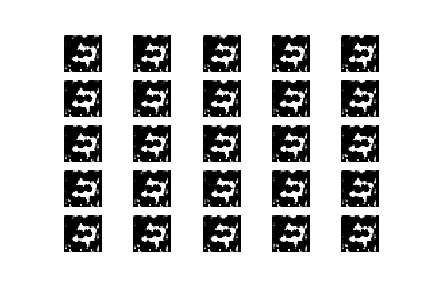

In [112]:
Image(filename=os.path.join(images_dir, 'mnist_1250.png'))

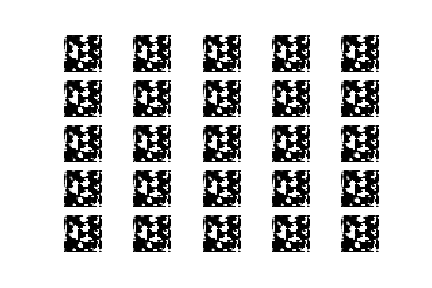

In [109]:
Image(filename=os.path.join(images_dir, 'mnist_2500.png'))

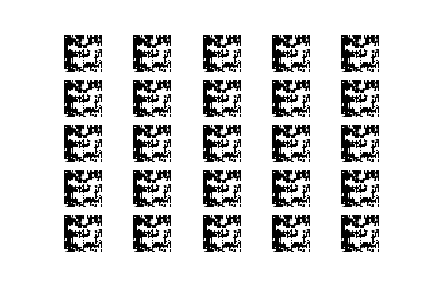

In [89]:
Image(filename=os.path.join(images_dir, 'mnist_2200.png'))

Let's have the trained model generate some images for us.

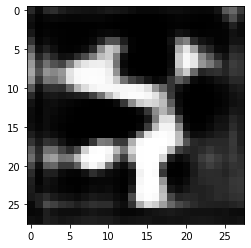

In [0]:
show_new_image(generator)

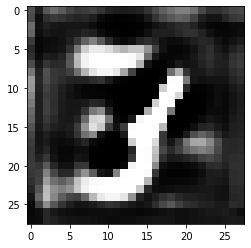

In [0]:
show_new_image(generator)

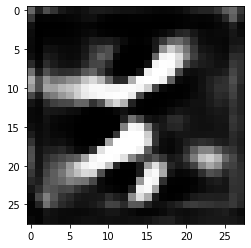

In [0]:
show_new_image(generator)

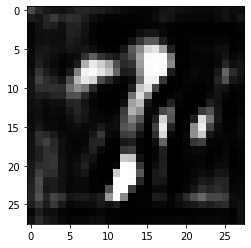

In [0]:
show_new_image(generator)

# Exercise Option 1
Change the model so that it learns to produce 9x9 images of some simple pattern, for instance horizontal lines.

# Exercise Option 2 (More Challenging)
Change the model so that you can select which number you get an image of rather than always getting a random one. I highly recommend that you limit your model to only learning two or three numbers, so that you can get decent results with less training time.

# Exercise Option 3 (More Challenging)
You may notice the current GAN with 2000 iterations only gives so-so output. Unfortunately, if you keep training past this point, the output just gets worse. I haven't yet been able to figure out how to change the model to get better results. Can you?